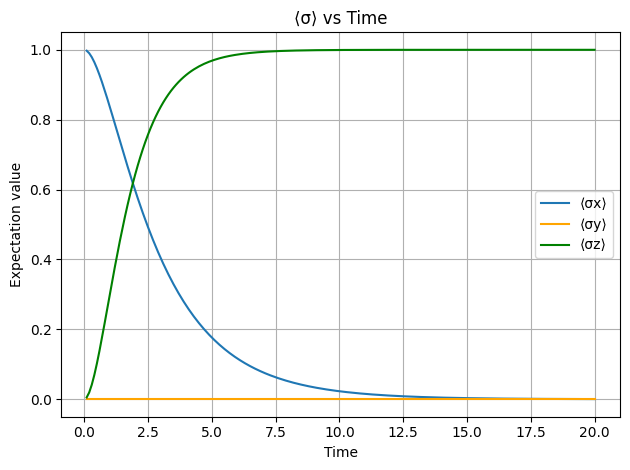

t = 0.10
Analytical rho_t:
 [[0.5026+0.j 0.4987+0.j]
 [0.4987+0.j 0.4974+0.j]]
QC simulated rho:
 [[0.5026 0.4987]
 [0.4987 0.4974]] 

t = 0.20
Analytical rho_t:
 [[0.5098+0.j 0.4951+0.j]
 [0.4951+0.j 0.4902+0.j]]
QC simulated rho:
 [[0.5098 0.4951]
 [0.4951 0.4902]] 

t = 0.30
Analytical rho_t:
 [[0.5208+0.j 0.4895+0.j]
 [0.4895+0.j 0.4792+0.j]]
QC simulated rho:
 [[0.5208 0.4895]
 [0.4895 0.4792]] 

t = 0.40
Analytical rho_t:
 [[0.5348+0.j 0.4823+0.j]
 [0.4823+0.j 0.4652+0.j]]
QC simulated rho:
 [[0.5348 0.4823]
 [0.4823 0.4652]] 

t = 0.50
Analytical rho_t:
 [[0.551 +0.j 0.4738+0.j]
 [0.4738+0.j 0.449 +0.j]]
QC simulated rho:
 [[0.551  0.4738]
 [0.4738 0.449 ]] 

t = 0.60
Analytical rho_t:
 [[0.569 +0.j 0.4642+0.j]
 [0.4642+0.j 0.431 +0.j]]
QC simulated rho:
 [[0.569  0.4642]
 [0.4642 0.431 ]] 

t = 0.70
Analytical rho_t:
 [[0.5882+0.j 0.4538+0.j]
 [0.4538+0.j 0.4118+0.j]]
QC simulated rho:
 [[0.5882 0.4538]
 [0.4538 0.4118]] 

t = 0.80
Analytical rho_t:
 [[0.608 +0.j 0.4427+0.j]
 [

In [16]:
import numpy as np
from qiskit.circuit.library import UnitaryGate
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from scipy.linalg import svd
from scipy.linalg import expm
from qutip import *
from numpy.linalg import eig
import matplotlib.pyplot as plt
from qutip import *
   
import numpy as np
import qutip as qt

lam = 1.1
gamma_0 = 0.5
if lam <= 2 * gamma_0:
    raise ValueError("The value of 'lam' must be greater than 2 * 'gamma_0' for the square root to be real.")
l = np.emath.sqrt(lam**2 - 2*gamma_0*lam)

# Your functions
def Expr(t):
    expression = ((-l**2 + lam**2) * np.sinh(l*t/2)) / (l*np.cosh(l*t/2) + lam*np.sinh(l*t/2))
    return expression

def gam(t):
    return np.real(Expr(t))

time = np.linspace(0.1,20,200 ) # Adjust time range as needed,

# Build Liouvillian matrices as numpy arrays
liouvillian_matrices = []
for t in time:
    gamma_t = gam(t)
    c_op = np.sqrt(gamma_t) * qt.sigmap()  # Collapse op includes rate
    L = qt.liouvillian(qt.Qobj(np.zeros((2, 2))), [c_op])
    # print(L.full())
    liouvillian_matrices.append(L)


exp_vals_x =[]
exp_vals_y =[]
exp_vals_z =[]




import numpy as np
from numpy.linalg import eig
from qutip import Qobj

def super_to_choi(q_oper: Qobj) -> (Qobj, int, int):
# Extract raw array and dims
    data = q_oper.full()
    dims = q_oper.dims  
    d0 = dims[0][0][0] 
    d1 = dims[1][0][0] 
    # Build the Choi array 
    choi_arr = (
        data.reshape((d0, d1, d0, d1))
            .transpose(3, 1, 2, 0)
            .reshape((d0*d1, d0*d1))
    )

    choi = Qobj(choi_arr,
                dims=[[ [d1], [d0] ],   # row dims = [d_out, d_in]
                      [ [d1], [d0] ]],  # col dims = same for a square 4×4 matrix
                superrep='choi')
    return choi, d0, d1


def choi_to_kraus(choi: Qobj, d0: int, d1: int, tol: float = 1e-9) -> list[Qobj]:
    # Eigen decomposition of the Choi matrix
    vals, vecs = eig(choi.full())
    kraus_ops = []
    for val, vec in zip(vals, vecs.T):
        if val > tol:
            mat = vec.reshape((d1, d0), order='F')
           
            K = Qobj(np.sqrt(val) * mat,
                     dims=[[d1], [d0]])
            kraus_ops.append(K)
    return kraus_ops


def super_to_kraus(q_oper: Qobj, tol: float = 1e-9) -> list[Qobj]:

    choi, d0, d1 = super_to_choi(q_oper)
    return choi_to_kraus(choi, d0, d1, tol)


# kraus_ops = super_to_kraus(superprop)
# 

def SVD(K):
    U, s, Vh = svd(K)
    sigma = np.diag(s)
    theta = np.arccos(np.clip(s, -1, 1))
    phases = np.concatenate([theta, -theta])
    U_sigma = np.diag(np.exp(1j * phases))
    return U, U_sigma, Vh

def Quantum_circuit(U, sigma, V):
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.append(UnitaryGate(V), [0])
    qc.h(1)
    qc.append(UnitaryGate(sigma), [0,1])
    qc.append(UnitaryGate(U), [0])
    qc.h(1)
    qc.save_statevector()
    sim = AerSimulator(method='statevector')
    tc = transpile(qc, sim)
    result = sim.run(tc, shots=1).result()
    sv = result.get_statevector(qc)

    
    psi =[]
    for i in range(2):
        psi.append(sv[i])
    qc.draw('mpl')  
    return np.outer(psi, np.conj(psi))
# times = np.linspace(0, 5, 5)
results = []

for idx, t in enumerate(time):
    
    L = (liouvillian_matrices[idx])      # Convert Qobj to numpy array
    superprop_mat = (t * L).expm()        # Matrix exponential
    kraus_ops = super_to_kraus(superprop_mat)
    rho_t = np.zeros((2,2), dtype=complex)
    
    for K1 in kraus_ops:
        K = K1.full()
        # print(K)
        rho_t += K @ np.array([[0.5,0.5],[0.5,0.5]]) @ K.conj().T
    
    # unitary dilation
    rho_sim = np.zeros((2,2), dtype=complex)
    
    for K in kraus_ops:
        K = K.full()
        U, sigma, V = SVD(K)
        rho_sim  += Quantum_circuit(U, sigma, V)
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    sigma_z = np.array([[1, 0], [0, -1]])

    exp_vals_x.append((np.real(np.trace((rho_sim @ sigma_x)))))
    exp_vals_y.append(np.real(np.trace(rho_sim @ sigma_y)))
    exp_vals_z.append(np.real(np.trace(np.dot(rho_sim, sigma_z))))
    
    
    results.append((rho_t, rho_sim.real))
    

# fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    
plt.plot(time,exp_vals_x, label="⟨σx⟩")
plt.title("⟨σ⟩ vs Time")
plt.xlabel("Time")
plt.ylabel("Expectation value")
plt.grid(True)

plt.plot(time, exp_vals_y, label="⟨σy⟩", color='orange')
plt.plot(time, exp_vals_z, label="⟨σz⟩", color='green')
plt.legend()

plt.tight_layout()
plt.show()



# Display comparison for each time
for idx, t in enumerate(time):
    print(f"t = {t:.2f}")
    print("Analytical rho_t:\n", np.round(results[idx][0],4))
    print("QC simulated rho:\n", np.round(results[idx][1],4), "\n")

# Display the quantum circuit